In [18]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from utils.DiceLoss import DiceLoss
from utils.JaccardIndex import JaccardIndex
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

In [19]:
# Incarcare imagini presegmentate
seg_folder = 'G:/MachineLearning/liver-database/outputs/'
models = ['DenseNet201', 'Inception', 'ResNet152', 'ResNeXt101']
seg = np.zeros((4, 4776, 512, 512), dtype=bool)
for i in range(len(models)):
    full_path = seg_folder + models[i]
    seg_files = glob.glob(full_path + '/*.ct')
    for j in range(len(seg_files)):
        seg[i, j, :, :] = np.fromfile(seg_files[j], dtype=np.int8).squeeze().reshape([512, 512]).astype(bool)
    print(f"Done loading {models[i]}")

seg = torch.tensor(seg)

# Incarcare ground truth
lits_seg = glob.glob('G:/MachineLearning/liver-database/validation/masks/*.ct')
ground_truth = np.zeros((4776, 512, 512), dtype=bool)
for j in range(len(lits_seg)):
    ground_truth[j, :, :] = np.fromfile(lits_seg[j], dtype=np.float16).squeeze().reshape([512, 512]).astype(bool)
print(f"Done loading ground truth")
ground_truth = torch.tensor(ground_truth)

Done loading DenseNet201
Done loading Inception
Done loading ResNet152
Done loading ResNeXt101
Done loading ground truth


In [20]:
# Evaluam DICE per case, average dice per slice si Jaccard
dice_loss = DiceLoss()
jaccard = JaccardIndex()

for i in range(len(models)):
    dice = 1.0 - dice_loss(ground_truth, seg[i, :, :, :].squeeze())
    print(f"Dice score average per case for {models[i]}: {dice:.3f}")
print('')
for i in range(len(models)):
    dice = 0
    for s in range(ground_truth.size(dim=0)):
        dice += (1.0 - dice_loss(ground_truth[s, :, :], seg[i, s, :, :]))
    dice = dice / ground_truth.size(dim=0)
    print(f"Dice score per slice average for {models[i]}: {dice:.3f}")
print('')
for i in range(len(models)):
    jcc_score = jaccard(ground_truth, seg[i, :, :, :].squeeze())
    print(f"Jaccard index average per case for {models[i]}: {jcc_score:.3f}")

Dice score average per case for DenseNet201: 0.921
Dice score average per case for Inception: 0.918
Dice score average per case for ResNet152: 0.954
Dice score average per case for ResNeXt101: 0.955

Dice score per slice average for DenseNet201: 0.929
Dice score per slice average for Inception: 0.938
Dice score per slice average for ResNet152: 0.939
Dice score per slice average for ResNeXt101: 0.949

Jaccard index average per case for DenseNet201: 0.854
Jaccard index average per case for Inception: 0.849
Jaccard index average per case for ResNet152: 0.912
Jaccard index average per case for ResNeXt101: 0.913


In [21]:
# Facem diferentele de segmentari
num_models = len(models)
diff_dice = torch.zeros(num_models, num_models)
for i in range(num_models):
    for j in range(num_models):
        diff_dice[i, j] = 1.0 - dice_loss(seg[i, :, :, :] ^ ground_truth, seg[j, :, :, :] ^ ground_truth)
diff_dice = diff_dice.cpu().numpy()

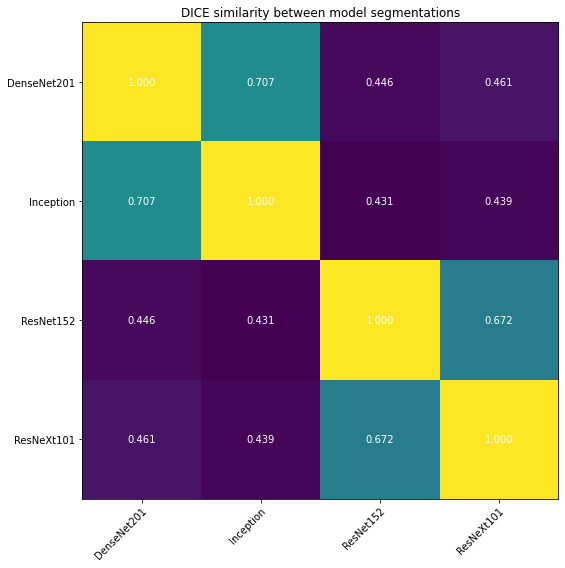

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(diff_dice)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(models)), labels=models)
ax.set_yticks(np.arange(len(models)), labels=models)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(models)):
    for j in range(len(models)):
        text = ax.text(j, i, ("%.3f" % diff_dice[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("DICE similarity between model segmentations")
fig.tight_layout()
plt.show()